## Convolutional Autoencoder arquitecture optimization

Con lo concluído en el anterior notebook, nos ocupamos de buscar la arquitectura de nuestro CAE -número de capas convolucionales y densas, número de filtros, funciones de activación, etc.- que mejor performance tenga ante los datos generados en 1.0; estandarizados con nuestro modelo RobustScaler.

In [1]:
import json
import pickle
import os
import warnings

from keras.wrappers.scikit_learn import KerasRegressor
from matplotlib import pyplot as plt 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import losses

from deep_scattering_models.data.create_data import load_data

from deep_scattering_models.features.preprocess_data import to_dB

from deep_scattering_models.models.convolutional_autoencoder import ConvAutoencoder

from deep_scattering_models.models.model_wrappers import build_cae_architecture

from deep_scattering_models.models.select_model import k_fold_cv, save_configuration

from deep_scattering_models.visualization.visualize import plot_polarization_signature, plot_history

Cargamos los datos crudos, para poder cargarlos en un pipline que los estandarice, pase a dB y les de forma para ingresar al CAE, en el contexto de una validación cruzada (cada uno de estos pasos debe realizarse en cada iteración, sin cruzar datos entre los folds de entrenamiento y testeo).

In [2]:
raw_data_filename = "raw/spm_signatures_no_noise"
raw_data = load_data(raw_data_filename)

In [3]:
data_dB = to_dB(raw_data)
train_set, test_set = train_test_split(
    data_dB, 
    test_size=.2, 
    random_state=123
    )

In [4]:
INPUT_SHAPE = (45, 90, 1)

Vamos a realizar un Grid Search barriendo varias arquitecturas posibles. Para eso definimos una grilla o espacio de parámetros, sobre el cual podemos obtener un modelo para cada un de las combinaciones posibles de parámetros y evaluar su performance con nuestros datos. Para que la evaluación sea más robusta, vamos a usar K-fold Cross Validation.

Comenzamos definiendo nuestra grilla de parámetros. Vamos a dejar fijo el parámetro correspondiente a la dimensión del espacio latente, en número bajo para optimizar el resto de la arquitectura -acá suponemos que la performance del modelo va a mejorar para dimensiones más altas del espacio latente-.

In [5]:
# Check GPU's 
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# Fijamos la dimensión del espacio latente
LATENT_DIMENTION = 10

# Configuracion de las capas convolucionales
cv_layers = [
    [(4, (7, 8), 2), (4, (5, 5), 1)],
    [(4, (3, 4), 2), (4, (3, 3), 1)],
    [(4, (3, 4), 2), (4, (3, 3), 1), (4, (3, 3), 1)],
    [(4, (3, 4), 2), (4, (4, 4), 2), (4, (3, 3), 1)],
    [(4, (3, 4), 2), (8, (3, 3), 1)],
    [(4, (3, 3), 1), (4, (3, 3), 1)],
    [(4, (3, 4), 2), (4, (4, 4), 2)],
    [(4, (3, 4), 2), (16, (4, 4), 2)],
    [(4, (3, 4), 2), (8, (4, 4), 2), (16, (3, 3), 1)],
    [(4, (3, 4), 2), (8, (4, 4), 2), (16, (3, 3), 1), (32, (3, 3), 1)]
]

max_pooling = [True,]

In [8]:
# Configuración de las capas densas
dense_layers = [
    (16,), (64,), (128), (256,),
    (32, 16), (16, 16), (32, 32),
    (256, 128), (256, 256), (256, 128, 64)
 ]

drop_out = [True,]

Una vez definida la grilla sobre la cual se va a hacer una búsqueda de hiperparámetros, hacemos una busqueda iterando sobre cada una de las configuraciones de la grilla. Para cada configuración vamos a realizar una k-fold cross validation con k=5.

In [9]:
configurations_score = []
best_configuration = {'score' : 1e4}
not_tested_configuration = []

for cv_layer in tqdm(cv_layers):
    for dense_layer in dense_layers:
        for pooling in max_pooling:
            for dropout in drop_out:
                # Configuración del modelo
                conv_configuration = dict(
                    layers_config=cv_layer,
                    max_pooling=pooling,
                    kernel_initializer= 'glorot_uniform'
                )

                dense_configuration = dict(
                    layers_units=dense_layer,
                    dropout=dropout
                )                

                configuration = {
                    'conv_layers_config': conv_configuration, 
                    'dense_layers_config': dense_configuration, 
                    'batch_size': 16
                }

                # k-fold cross validation
                try:
                    k_fold_score = k_fold_cv(
                        train_set, build_cae_architecture, configuration
                    )
                
                except tf.errors.ResourceExhaustedError:
                    # En el caso de agotar los recursos
                    not_tested_configuration.append(configuration)
                    
                    warnings.warn(
                        ('La actual configuración agotó los recursos '
                        f'de memoria y no fue evaluada: \n {configuration}'), 
                        RuntimeWarning
                        )

                else:
                    # Actualizo los scores de las configuraciones
                    configuration.update(k_fold_score)
                    configurations_score.append(configuration)
                        
                    if configuration['score'] < best_configuration['score']:
                        best_configuration = configuration 
                
                finally:
                    continue        
         

 10%|█         | 1/10 [3:01:33<27:14:00, 10893.36s/it]

Visualizamos los puntajes de las distintas configuraciones ordenados por score

In [ ]:
df_scores = pd.DataFrame.from_records(configurations_score).sort_values(by='score')
df_scores['conv_layers_config'] = df_scores['conv_layers_config'].apply(lambda x: x['layers_config'])
df_scores['dense_layers_config'] = df_scores['dense_layers_config'].apply(lambda x: x['layers_units'])
df_scores

,conv_layers_config,dense_layers_config,batch_size,score,train_score
16,"[(4, (3, 4), 2), (4, (3, 3), 1), (4, (3, 3), 1)]","(256,)",32,0.203934,0.229363
23,"[(4, (3, 4), 2), (4, (4, 4), 2), (4, (3, 3), 1)]","(256,)",32,0.212408,0.239723
9,"[(4, (3, 4), 2), (4, (3, 3), 1)]","(256,)",32,0.221224,0.247967
15,"[(4, (3, 4), 2), (4, (3, 3), 1), (4, (3, 3), 1)]","(64,)",32,0.243262,0.300989
8,"[(4, (3, 4), 2), (4, (3, 3), 1)]","(64,)",32,0.269199,0.303082
2,"[(4, (7, 8), 2), (4, (5, 5), 1)]","(256,)",32,0.274353,0.306939
22,"[(4, (3, 4), 2), (4, (4, 4), 2), (4, (3, 3), 1)]","(64,)",32,0.277678,0.316934
1,"[(4, (7, 8), 2), (4, (5, 5), 1)]","(64,)",32,0.291982,0.367192
13,"[(4, (3, 4), 2), (4, (3, 3), 1)]","(256, 128)",32,0.378211,0.427426
27,"[(4, (3, 4), 2), (4, (4, 4), 2), (4, (3, 3), 1)]","(256, 128)",32,0.420351,0.476315


Guardo los scores y la arquitectura con mejor score

In [ ]:
# Get resutls directory path
src_dir = os.path.normpath(os.getcwd() + '/..')
results_dir = os.path.join(src_dir, 'results/spm')

# File name and dir
file_name = 'architectures_scores.pkl'
file_dir = os.path.join(results_dir, file_name)

# Save model_scores as pkl
with open(file_dir, 'wb') as f:
    pickle.dump(configurations_score, f)

In [ ]:
save_configuration(
    best_configuration, 
    filename='model_architecture'
    )

Configuration saved at /home/jotavecorta/proyectos/tesis/src/models/model_architecture_spm.json


Entrenemos un modelo con la mejor arquitectura y veamos cómo reconstruye las firmas

In [2]:
# Get models directory path
src_dir = os.path.normpath(os.getcwd() + '/..')
model_dir = os.path.join(src_dir, 'models') 

json_path = os.path.join(model_dir, 'model_architecture_spm.json')

with open(json_path, 'r') as file_:
    best_configuration = json.load(file_)  

print(best_configuration)    

{'conv_layers_config': {'layers_config': [[4, [3, 4], 2], [4, [3, 3], 1], [4, [3, 3], 1]], 'max_pooling': True, 'kernel_initializer': 'glorot_uniform'}, 'dense_layers_config': {'layers_units': [256], 'dropout': True}, 'batch_size': 32, 'score': 0.2039342664927244, 'train_score': 0.22936312660574912}


In [3]:
# Datos estandarizados con robust scaler
rs_train_filename="processed/spm_signatures_beta_scale_train_set"
rs_test_filename="processed/spm_signatures_beta_scale_test_set"

rscaled_train = load_data(rs_train_filename)
rscaled_test = load_data(rs_test_filename)

In [4]:
data_shape = rscaled_train.shape[1:]

# Inicializo un cae con la mejor arquitectura
best_cae = ConvAutoencoder(
    latent_dim=10, 
    input_shape=data_shape,
    conv_layers=best_configuration['conv_layers_config'],
    dense_layers=best_configuration['dense_layers_config']
    ) 

<AxesSubplot:title={'center':'Model train history'}, xlabel='Epochs', ylabel='Mean Absolute Error'>

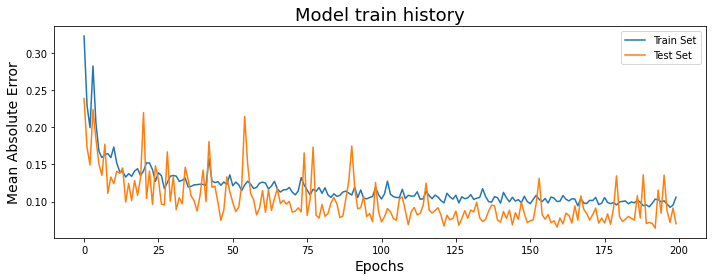

In [5]:
# Compilamos y ajustamos nuestro modelo con los datos estandarizados
best_cae.compile(
    optimizer='adam', 
    loss=losses.MeanSquaredError(), 
    metrics=['mean_absolute_error', 'mean_squared_error']
    )

history = best_cae.fit(
    rscaled_train, 
    rscaled_train,
    epochs=200,
    batch_size=32,
    verbose=0,
    validation_data=(rscaled_test, rscaled_test)
    )

plot_history(history)

In [24]:
tf.keras.backend.clear_session()
del best_cae

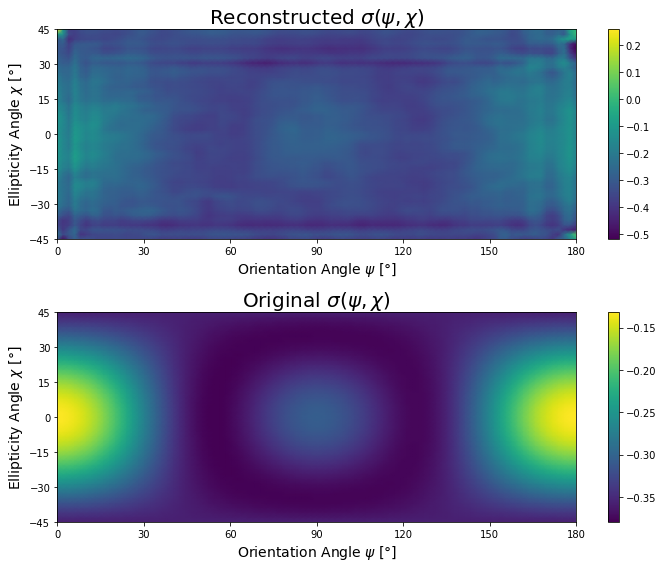

In [11]:
# Genero y decodifico imagenes de testeo
encoded_imgs = best_cae.encoder(rscaled_test[:1000]).numpy()
decoded_imgs = best_cae.decoder(encoded_imgs).numpy()

# Elegimos ana firma al azar
rng = np.random.default_rng()
rnd_index = rng.integers(decoded_imgs.shape[0])
rnd_reconstruct_signature = decoded_imgs[rnd_index, :, :, 0]
rnd_signature = rscaled_test[rnd_index, :, :, 0]

# Ploteamos
fig, ax = plt.subplots(2, 1)

plot_polarization_signature(rnd_reconstruct_signature, ax=ax[0])
plot_polarization_signature(rnd_signature, ax=ax[1])

ax[0].set_title(r'Reconstructed $\sigma(\psi,\chi)$', fontsize = 20)
ax[1].set_title(r'Original $\sigma(\psi,\chi)$', fontsize = 20)

fig.tight_layout()

Para ver si el error de reconstrucción es aceptable, tenemos que pasar de MAE a dB. Para eso cargamos el objeto con el que estandarizamos las imágenes, y utilizamos los atributos mean y iqr para volver a dB.

In [7]:
# Get path to scaler and unpickle it
model_path = os.path.normpath("../models/robust_scaler.pkl")

with open(model_path, "rb") as file_:
    scaler = pickle.load(file_)

# Extract train set mean and iqr
mean = scaler.center_
iqr = scaler.scale_   

In [28]:
# Transform test adn train mean absolute error per epoch to dB
train_mae = np.array(history.history["mean_absolute_error"])
test_mae = np.array(history.history["val_mean_absolute_error"])

dB_error = dict(
    mean_absolute_error = train_mae * np.mean(iqr) + np.mean(mean),
    val_mean_absolute_error = test_mae * np.mean(iqr) + np.mean(mean)
)

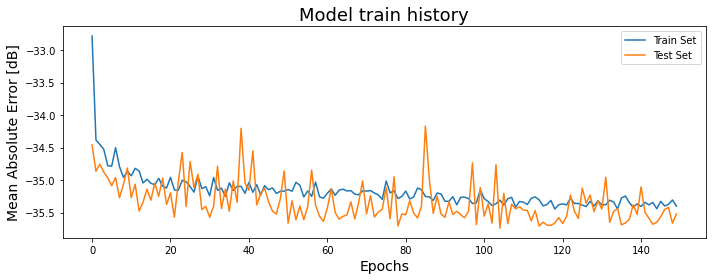

In [29]:
fig, ax = plt.subplots(1, 1)

# Plot scores in ax
ax.plot(dB_error["mean_absolute_error"], label='Train Set')
ax.plot(dB_error["val_mean_absolute_error"], label='Test Set')

ax.set_xlabel("Epochs", fontsize=14)
ax.set_ylabel("Mean Absolute Error [dB]", fontsize=14)
ax.set_title("Model train history", fontsize=18)
ax.legend()

fig.set_figheight(4)
fig.set_figwidth(10)
fig.tight_layout()